Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257


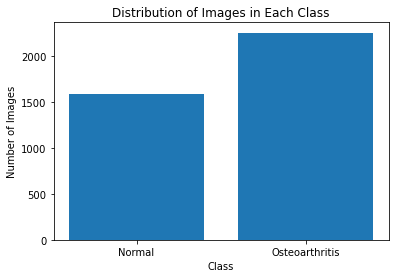

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Create a histogram to visualize the distribution of images in each class
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


2024-03-23 12:36:57.955914: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-23 12:36:58.145145: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 12:36:58.145184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 12:36:58.178265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 12:36:58.245917: I tensorflow/core/platform/cpu_feature_guar

Number of images in Normal class: 1589
Number of images in Osteoarthritis class: 2257
Number of images in Normal class after augmentation: 2257


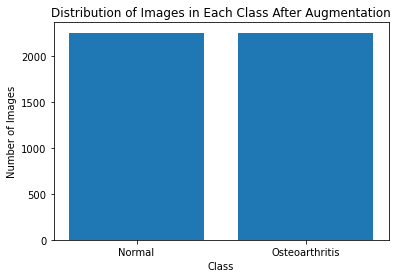

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define a function to load and resize images from a folder
def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            images.append(img)
    return images

# Load images from directories for each class
normal_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Normal')
osteoarthritis_images = load_and_resize_images_from_folder('/home/lab5/ML2/OsteoArthritis-20240311T154242Z-001/OsteoArthritis/Osteoarthritis')

# Display the number of images in each class
print("Number of images in Normal class:", len(normal_images))
print("Number of images in Osteoarthritis class:", len(osteoarthritis_images))

# Check if data augmentation is needed
if len(normal_images) < len(osteoarthritis_images):
    # Calculate the number of additional images needed
    num_additional_images = len(osteoarthritis_images) - len(normal_images)

    # Create an ImageDataGenerator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Choose random indices from the "Normal" class for augmentation
    sampled_indices = np.random.randint(0, len(normal_images), size=num_additional_images)

    # Perform data augmentation and append augmented images to the "Normal" class
    for index in sampled_indices:
        img = normal_images[index]
        img = img.reshape((1,) + img.shape)  # Reshape for flow() function
        for batch in datagen.flow(img, batch_size=1):
            normal_images.append(batch[0])  # Append augmented images
            break  # Exit the loop after one iteration of data augmentation

    # Display the number of images in the "Normal" class after augmentation
    print("Number of images in Normal class after augmentation:", len(normal_images))

# Create a histogram to visualize the distribution of images in each class after augmentation
plt.bar(['Normal', 'Osteoarthritis'], [len(normal_images), len(osteoarthritis_images)])
plt.title('Distribution of Images in Each Class After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


In [3]:
import random

# Set a seed for reproducibility
random.seed(42)

# Randomly select 1000 images from each class
selected_normal_images = random.sample(normal_images, 2000)
selected_osteoarthritis_images = random.sample(osteoarthritis_images, 2000)

# Combine selected images from both classes
selected_images = selected_normal_images + selected_osteoarthritis_images
labels = [0] * 2000 + [1] * 2000  # Assign labels (0 for Normal, 1 for Osteoarthritis)

# Split the selected images and labels into train and test sets (70:30 ratio)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(selected_images, labels, test_size=0.3, random_state=42)

# Split the train set into train and validation sets (80:20 ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Print the sizes of train, test, and validation sets
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))
print("X_validation size:", len(X_val))


X_train size: 2240
X_test size: 1200
X_validation size: 560


# MobileNet+Dense

In [4]:
import pandas as pd
from sklearn.metrics import balanced_accuracy_score,matthews_corrcoef,cohen_kappa_score

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

import numpy as np

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [5]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 201ms/step - loss: 0.4779 - accuracy: 0.7786 - val_loss: 0.3638 - val_accuracy: 0.8429
Epoch 2/50
70/70 [==============================] - 14s 198ms/step - loss: 0.3023 - accuracy: 0.8737 - val_loss: 0.2808 - val_accuracy: 0.8786
Epoch 3/50
70/70 [==============================] - 14s 201ms/step - loss: 0.2572 - accuracy: 0.8866 - val_loss: 0.3398 - val_accuracy: 0.8446
Epoch 4/50
70/70 [==============================] - 14s 198ms/step - loss: 0.2157 - accuracy: 0.9138 - val_loss: 0.2783 - val_accuracy: 0.8911
Epoch 5/50
70/70 [==============================] - 14s 198ms/step - loss: 0.2083 - accuracy: 0.9112 - val_loss: 0.3021 - val_accuracy: 0.8732
Epoch 6/50
70/70 [==============================] - 14s 199ms/step - loss: 0.1697 - accuracy: 0.9375 - val_loss: 0.2767 - val_accuracy: 0.8821
Epoch 7/50
70/70 [==============================] - 14s 201ms/step - loss: 0.1483 - accuracy: 0.9451 - val_loss: 0.4670 - val_accuracy: 0.8375

Validation Loss: 0.26517948508262634
Validation Accuracy: 0.8910714387893677
Test Loss: 0.26743826270103455
Test Accuracy: 0.8891666531562805
Inference Time (Test set): 9.158857107162476 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       622
           1       0.92      0.84      0.88       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

Confusion Matrix:
[[582  40]
 [ 93 485]]


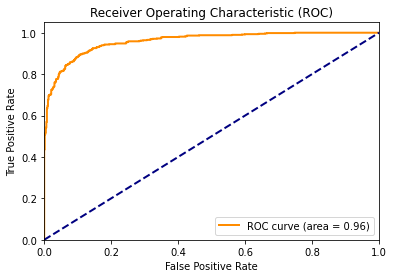

Metrics saved successfully


In [6]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd
# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 14s 204ms/step - loss: 0.1419 - accuracy: 0.9438 - val_loss: 0.2747 - val_accuracy: 0.8946
Epoch 2/100
70/70 [==============================] - 14s 203ms/step - loss: 0.1133 - accuracy: 0.9571 - val_loss: 0.2652 - val_accuracy: 0.8982
Epoch 3/100
70/70 [==============================] - 14s 203ms/step - loss: 0.0918 - accuracy: 0.9688 - val_loss: 0.3667 - val_accuracy: 0.8821
Epoch 4/100
70/70 [==============================] - 14s 203ms/step - loss: 0.1104 - accuracy: 0.9571 - val_loss: 0.2952 - val_accuracy: 0.8857
Epoch 5/100
70/70 [==============================] - 14s 203ms/step - loss: 0.0797 - accuracy: 0.9683 - val_loss: 0.2925 - val_accuracy: 0.8911
Epoch 6/100
70/70 [==============================] - 14s 202ms/step - loss: 0.0670 - accuracy: 0.9759 - val_loss: 0.3370 - val_accuracy: 0.8804
Epoch 7/100
70/70 [==============================] - 14s 202ms/step - loss: 0.0727 - accuracy: 0.9692 - val_loss: 0.3479 - val_accuracy:

Validation Loss: 0.2652096748352051
Validation Accuracy: 0.8982142806053162
Test Loss: 0.2668546736240387
Test Accuracy: 0.8933333158493042
Inference Time (Test set): 9.073232173919678 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       622
           1       0.91      0.87      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

Confusion Matrix:
[[571  51]
 [ 77 501]]


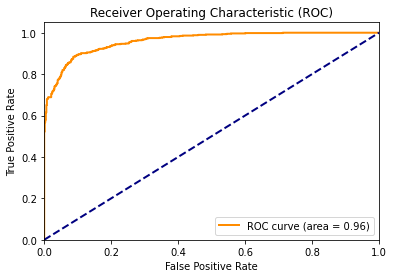

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 14s 205ms/step - loss: 0.1121 - accuracy: 0.9612 - val_loss: 0.2865 - val_accuracy: 0.9018
Epoch 2/150
70/70 [==============================] - 14s 203ms/step - loss: 0.0759 - accuracy: 0.9746 - val_loss: 0.3019 - val_accuracy: 0.8929
Epoch 3/150
70/70 [==============================] - 14s 203ms/step - loss: 0.0757 - accuracy: 0.9746 - val_loss: 0.3736 - val_accuracy: 0.8750
Epoch 4/150
70/70 [==============================] - 14s 203ms/step - loss: 0.1111 - accuracy: 0.9513 - val_loss: 0.3569 - val_accuracy: 0.8768
Epoch 5/150
70/70 [==============================] - 14s 203ms/step - loss: 0.0690 - accuracy: 0.9772 - val_loss: 0.3336 - val_accuracy: 0.8893
Epoch 6/150
70/70 [==============================] - 14s 204ms/step - loss: 0.0506 - accuracy: 0.9848 - val_loss: 0.3010 - val_accuracy: 0.8929
Training Time: 85.88545894622803 seconds


Validation Loss: 0.28646406531333923
Validation Accuracy: 0.9017857313156128
Test Loss: 0.2763538062572479
Test Accuracy: 0.8899999856948853
Inference Time (Test set): 9.12173581123352 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       622
           1       0.88      0.90      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

Confusion Matrix:
[[548  74]
 [ 58 520]]


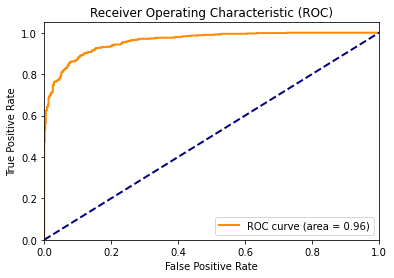

Metrics saved successfully


In [10]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

metrics={
    'Combination':'MObilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")



In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 14s 205ms/step - loss: 0.1278 - accuracy: 0.9451 - val_loss: 0.3591 - val_accuracy: 0.8750
Epoch 2/200
70/70 [==============================] - 14s 203ms/step - loss: 0.0938 - accuracy: 0.9661 - val_loss: 0.3204 - val_accuracy: 0.8929
Epoch 3/200
70/70 [==============================] - 14s 203ms/step - loss: 0.0785 - accuracy: 0.9728 - val_loss: 0.4279 - val_accuracy: 0.8661
Epoch 4/200
70/70 [==============================] - 14s 202ms/step - loss: 0.0687 - accuracy: 0.9759 - val_loss: 0.3942 - val_accuracy: 0.8679
Epoch 5/200
70/70 [==============================] - 14s 203ms/step - loss: 0.0544 - accuracy: 0.9844 - val_loss: 0.3556 - val_accuracy: 0.8857
Epoch 6/200
70/70 [==============================] - 14s 202ms/step - loss: 0.0703 - accuracy: 0.9728 - val_loss: 0.3207 - val_accuracy: 0.8857
Epoch 7/200
70/70 [==============================] - 14s 203ms/step - loss: 0.0534 - accuracy: 0.9844 - val_loss: 0.3739 - val_accuracy:

Validation Loss: 0.32039088010787964
Validation Accuracy: 0.8928571343421936
Test Loss: 0.3180790841579437
Test Accuracy: 0.8733333349227905
Inference Time (Test set): 9.045462369918823 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       622
           1       0.89      0.84      0.86       578

    accuracy                           0.87      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.87      0.87      0.87      1200

Confusion Matrix:
[[565  57]
 [ 95 483]]


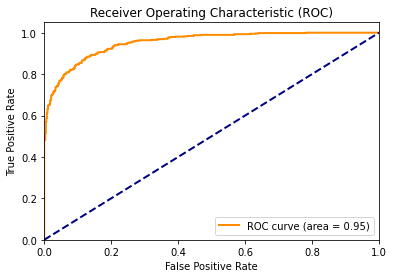

Metrics saved successfully


In [12]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


metrics={
    'Combination':'Mobilenet+Dense',
    'Validation Accuracy':val_accuracy*100,
    'Validation Loss':val_loss,
    'Test Accuracy':test_accuracy*100,
    'Test Loss':test_loss,
    'Training time':training_time,
    'Inference time':inference_time,
    'Cohens Kappa':kappa,
    'MCC':mcc,
    'Balanced Accuracy':balanced_accuracy
}
metrics_df=pd.DataFrame(metrics,index=[0])
metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")


# MobileNet+Dense+Dropout

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add dropout regularization
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

# Define the number of output classes based on your data
num_classes = len(np.unique(y_train))

# Add a final classification layer with softmax activation
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [14]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 206ms/step - loss: 0.7537 - accuracy: 0.5040 - val_loss: 0.6925 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 14s 202ms/step - loss: 0.7028 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.5393
Epoch 3/50
70/70 [==============================] - 14s 202ms/step - loss: 0.6974 - accuracy: 0.5121 - val_loss: 0.6907 - val_accuracy: 0.5143
Epoch 4/50
70/70 [==============================] - 14s 202ms/step - loss: 0.6936 - accuracy: 0.5071 - val_loss: 0.7012 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 14s 202ms/step - loss: 0.6965 - accuracy: 0.4853 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 14s 202ms/step - loss: 0.6929 - accuracy: 0.5147 - val_loss: 0.6921 - val_accuracy: 0.4875
Epoch 7/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6934 - accuracy: 0.5103 - val_loss: 0.6926 - val_accuracy: 0.5482

Validation Loss: 0.6894407868385315
Validation Accuracy: 0.5392857193946838
Test Loss: 0.6891254186630249
Test Accuracy: 0.5475000143051147
Inference Time (Test set): 9.224270343780518 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.99      0.69       622
           1       0.84      0.07      0.14       578

    accuracy                           0.55      1200
   macro avg       0.69      0.53      0.42      1200
weighted avg       0.68      0.55      0.43      1200

Confusion Matrix:
[[614   8]
 [535  43]]


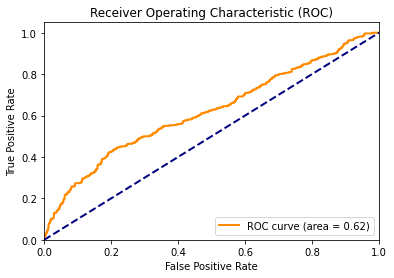

Metrics saved successfully


In [15]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")


In [16]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6995 - accuracy: 0.5116 - val_loss: 0.6912 - val_accuracy: 0.5982
Epoch 2/100
70/70 [==============================] - 14s 202ms/step - loss: 0.6944 - accuracy: 0.5076 - val_loss: 0.6997 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6936 - accuracy: 0.5147 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6924 - accuracy: 0.5241 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6931 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6933 - accuracy: 0.4938 - val_loss: 0.6930 - val_accuracy: 0.4875
Training Time: 85.50374817848206 seconds


Validation Loss: 0.6912043690681458
Validation Accuracy: 0.5982142686843872
Test Loss: 0.6913111805915833
Test Accuracy: 0.6133333444595337
Inference Time (Test set): 9.05657148361206 seconds
38/38 [==============================] - 6s 157ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.65       622
           1       0.62      0.52      0.56       578

    accuracy                           0.61      1200
   macro avg       0.61      0.61      0.61      1200
weighted avg       0.61      0.61      0.61      1200

Confusion Matrix:
[[435 187]
 [277 301]]


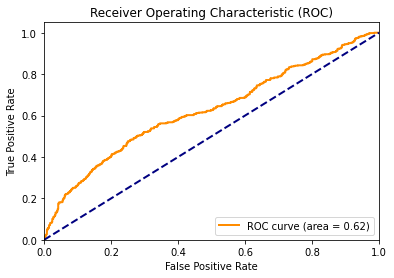

Metrics saved successfully


In [17]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")



In [18]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6945 - accuracy: 0.5013 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6946 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 14s 197ms/step - loss: 0.6929 - accuracy: 0.5179 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 4/150
70/70 [==============================] - 14s 197ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6927 - val_accuracy: 0.4893
Epoch 5/150
70/70 [==============================] - 14s 197ms/step - loss: 0.6930 - accuracy: 0.5107 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 6/150
70/70 [==============================] - 14s 196ms/step - loss: 0.6927 - accuracy: 0.5085 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 7/150
70/70 [==============================] - 14s 197ms/step - loss: 0.6926 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy:

Validation Loss: 0.6926705837249756
Validation Accuracy: 0.4892857074737549
Test Loss: 0.6927044987678528
Test Accuracy: 0.4883333444595337
Inference Time (Test set): 8.882003545761108 seconds
38/38 [==============================] - 6s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.02      0.03       622
           1       0.48      1.00      0.65       578

    accuracy                           0.49      1200
   macro avg       0.66      0.51      0.34      1200
weighted avg       0.67      0.49      0.33      1200

Confusion Matrix:
[[ 10 612]
 [  2 576]]


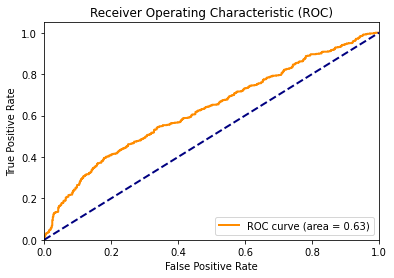

Metrics saved successfully


In [19]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)


# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")


In [20]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 14s 199ms/step - loss: 0.6931 - accuracy: 0.5049 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6932 - accuracy: 0.5098 - val_loss: 0.6931 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6924 - accuracy: 0.5129 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6927 - accuracy: 0.5129 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 7/200
70/70 [==============================] - 14s 198ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy:

Validation Loss: 0.6930636167526245
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6931328177452087
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 8.82266354560852 seconds
38/38 [==============================] - 6s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


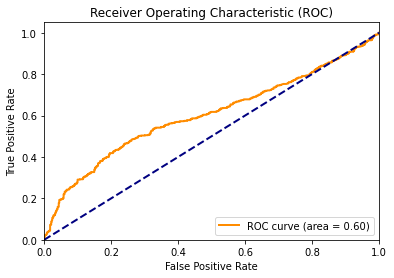

Metrics saved successfully


In [21]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Dense+Dropout'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense

In [22]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Conv2D, Dropout
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add a Conv2D layer
x = Conv2D(64, (3, 3), activation='relu', padding='same')(base_model.output)

# Add a global average pooling layer
x = GlobalAveragePooling2D()(x)

# Add a dropout layer
x = Dropout(0.5)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [23]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 207ms/step - loss: 0.7055 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6937 - accuracy: 0.4911 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6949 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6933 - accuracy: 0.5063 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 14s 204ms/step - loss: 0.6932 - accuracy: 0.5121 - val_loss: 0.6935 - val_accuracy: 0.4875
Epoch 7/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875

Validation Loss: 0.6935076117515564
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6936440467834473
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.004089832305908 seconds
38/38 [==============================] - 6s 156ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


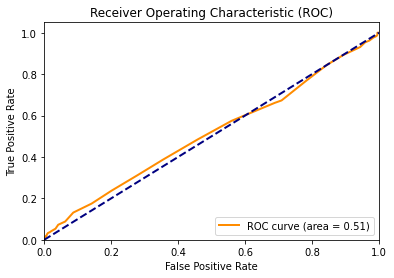

Metrics saved successfully


In [24]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score,cohen_kappa_score,matthews_corrcoef
import pandas as pd

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [25]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 14s 205ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 2/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 14s 206ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6938 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 15s 213ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 15s 212ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 15s 209ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 7/100
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy:

Validation Loss: 0.6938201189041138
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6940461993217468
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.31544017791748 seconds
38/38 [==============================] - 6s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


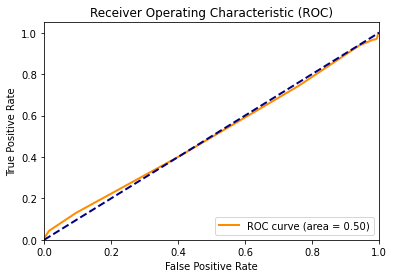

Metrics saved successfully


In [26]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [27]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 15s 211ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6944 - val_accuracy: 0.4875
Epoch 4/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6945 - val_accuracy: 0.4875
Epoch 5/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 6/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 7/150
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy:

Validation Loss: 0.6938635110855103
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6941010355949402
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.300264596939087 seconds
38/38 [==============================] - 6s 160ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


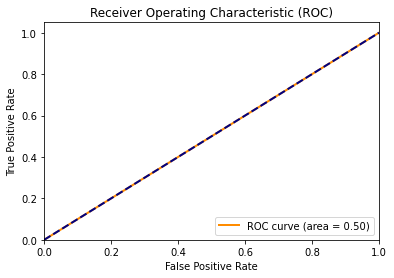

Metrics saved successfully


In [28]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [29]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 15s 211ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 15s 208ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 15s 210ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 15s 208ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6944 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 15s 209ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 15s 209ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 7/200
70/70 [==============================] - 15s 208ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy:

Validation Loss: 0.693852961063385
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6940878033638
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.248977899551392 seconds
38/38 [==============================] - 6s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


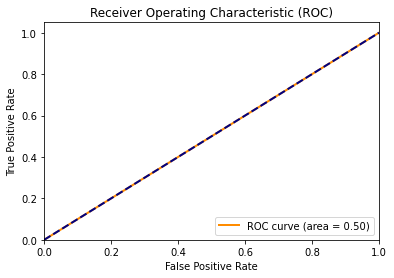

Metrics saved successfully


In [30]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Conv2D+GlobalAveragePooling+Dropout+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+LSTM+Dense

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224,224,3)  # Assuming you're using 224x224 images

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Global Average Pooling layer to reduce spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)

# Reshape to (batch_size, timesteps, features) for LSTM input
x = tf.expand_dims(x, axis=1)  # Expand dimensions to add a timestep dimension

# Add LSTM layer
x = LSTM(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [35]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 16s 205ms/step - loss: 0.6962 - accuracy: 0.4978 - val_loss: 0.6930 - val_accuracy: 0.5125
Epoch 2/50
70/70 [==============================] - 14s 198ms/step - loss: 0.6948 - accuracy: 0.4879 - val_loss: 0.6954 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 14s 200ms/step - loss: 0.6938 - accuracy: 0.5013 - val_loss: 0.6953 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 14s 200ms/step - loss: 0.6933 - accuracy: 0.5129 - val_loss: 0.6934 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 14s 195ms/step - loss: 0.6934 - accuracy: 0.5022 - val_loss: 0.6961 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 13s 189ms/step - loss: 0.6931 - accuracy: 0.4987 - val_loss: 0.6945 - val_accuracy: 0.4875
Training Time: 84.92827773094177 seconds


Validation Loss: 0.6930058002471924
Validation Accuracy: 0.512499988079071
Test Loss: 0.6929298043251038
Test Accuracy: 0.5183333158493042
Inference Time (Test set): 9.05596137046814 seconds
38/38 [==============================] - 6s 160ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       622
           1       0.00      0.00      0.00       578

    accuracy                           0.52      1200
   macro avg       0.26      0.50      0.34      1200
weighted avg       0.27      0.52      0.35      1200

Confusion Matrix:
[[622   0]
 [578   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


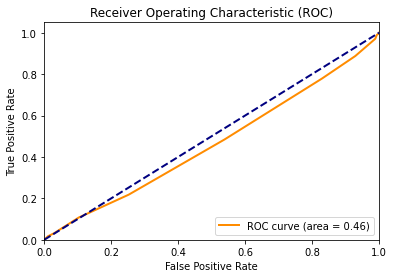

Metrics saved successfully


In [36]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [37]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 15s 212ms/step - loss: 0.6961 - accuracy: 0.4987 - val_loss: 0.6967 - val_accuracy: 0.4875
Epoch 2/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6933 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6934 - accuracy: 0.4951 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6953 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 7/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy:

Validation Loss: 0.6932848691940308
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6933431029319763
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.200983762741089 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


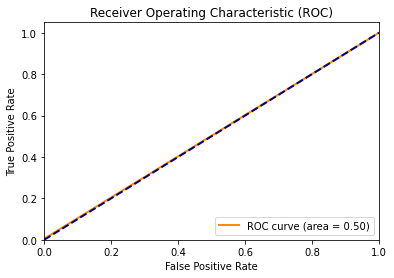

Metrics saved successfully


In [38]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [39]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 14s 206ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 4/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 5/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy: 0.4875
Epoch 6/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 7/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6941 - val_accuracy:

Validation Loss: 0.6936720609664917
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6938579082489014
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.134107112884521 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


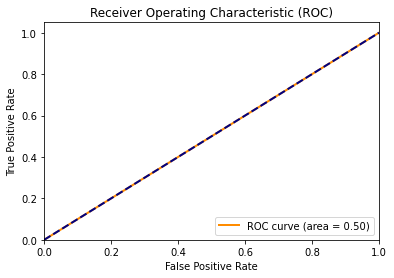

Metrics saved successfully


In [40]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [41]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 14s 205ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6944 - val_accuracy: 0.4875
Training Time: 85.64793086051941 seconds


Validation Loss: 0.69362473487854
Validation Accuracy: 0.48750001192092896
Test Loss: 0.693796694278717
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.12314772605896 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


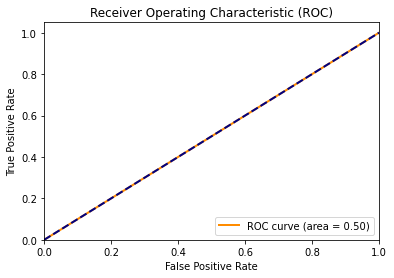

Metrics saved successfully


In [42]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+LSTM+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+GRU+Dense

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)  # Assuming you're using 224x224 images

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Global Average Pooling layer to reduce spatial dimensions
x = GlobalAveragePooling2D()(base_model.output)

# Reshape to (batch_size, timesteps, features) for GRU input
x = tf.expand_dims(x, axis=1)  # Expand dimensions to add a timestep dimension

# Add GRU layer
x = GRU(128)(x)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming num_classes is the number of output classes

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [45]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 203ms/step - loss: 0.6992 - accuracy: 0.5112 - val_loss: 0.6995 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 14s 200ms/step - loss: 0.6952 - accuracy: 0.5067 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 14s 201ms/step - loss: 0.6943 - accuracy: 0.5156 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 4/50
70/70 [==============================] - 14s 200ms/step - loss: 0.6938 - accuracy: 0.4951 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 14s 199ms/step - loss: 0.6948 - accuracy: 0.5094 - val_loss: 0.6945 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6940 - accuracy: 0.5085 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 7/50
70/70 [==============================] - 14s 206ms/step - loss: 0.6933 - accuracy: 0.5067 - val_loss: 0.6928 - val_accuracy: 0.5125

Validation Loss: 0.6928387880325317
Validation Accuracy: 0.512499988079071
Test Loss: 0.692513644695282
Test Accuracy: 0.5183333158493042
Inference Time (Test set): 9.15132737159729 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       622
           1       0.00      0.00      0.00       578

    accuracy                           0.52      1200
   macro avg       0.26      0.50      0.34      1200
weighted avg       0.27      0.52      0.35      1200

Confusion Matrix:
[[622   0]
 [578   0]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


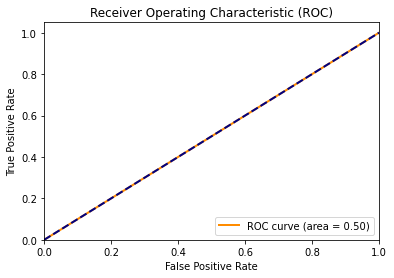

Metrics saved successfully


In [46]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [47]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 14s 206ms/step - loss: 0.6933 - accuracy: 0.5076 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 2/100
70/70 [==============================] - 14s 205ms/step - loss: 0.6934 - accuracy: 0.5031 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 3/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6935 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy: 0.4875
Epoch 4/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 5/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 7/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6945 - val_accuracy:

Validation Loss: 0.6935155391693115
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6936543583869934
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.292941570281982 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


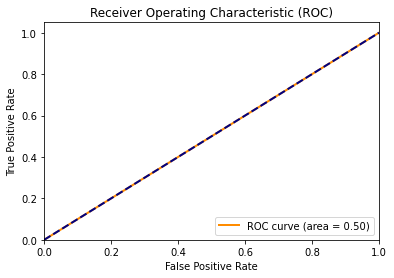

Metrics saved successfully


In [48]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [49]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 14s 205ms/step - loss: 0.6930 - accuracy: 0.4987 - val_loss: 0.6947 - val_accuracy: 0.4875
Epoch 2/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6936 - accuracy: 0.5076 - val_loss: 0.6932 - val_accuracy: 0.4875
Epoch 3/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 4/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6945 - val_accuracy: 0.4875
Epoch 5/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6934 - accuracy: 0.5129 - val_loss: 0.6936 - val_accuracy: 0.4875
Epoch 6/150
70/70 [==============================] - 14s 205ms/step - loss: 0.6932 - accuracy: 0.5129 - val_loss: 0.6933 - val_accuracy: 0.4875
Epoch 7/150
70/70 [==============================] - 14s 205ms/step - loss: 0.6931 - accuracy: 0.5085 - val_loss: 0.6938 - val_accuracy:

Validation Loss: 0.6932269334793091
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6932621002197266
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.139675378799438 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


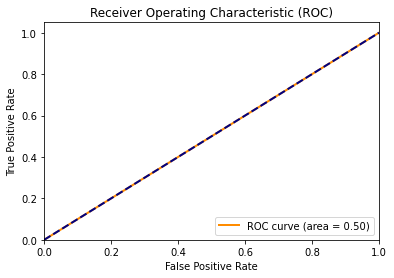

Metrics saved successfully


In [50]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [51]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 14s 204ms/step - loss: 0.6932 - accuracy: 0.5076 - val_loss: 0.6949 - val_accuracy: 0.4875
Epoch 2/200
70/70 [==============================] - 14s 205ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6937 - val_accuracy: 0.4875
Epoch 3/200
70/70 [==============================] - 14s 206ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6943 - val_accuracy: 0.4875
Epoch 4/200
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6944 - val_accuracy: 0.4875
Epoch 5/200
70/70 [==============================] - 14s 204ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.6939 - val_accuracy: 0.4875
Epoch 6/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6930 - accuracy: 0.5129 - val_loss: 0.6940 - val_accuracy: 0.4875
Epoch 7/200
70/70 [==============================] - 14s 204ms/step - loss: 0.6929 - accuracy: 0.5129 - val_loss: 0.6942 - val_accuracy:

Validation Loss: 0.6936933994293213
Validation Accuracy: 0.48750001192092896
Test Loss: 0.6938851475715637
Test Accuracy: 0.4816666543483734
Inference Time (Test set): 9.174601793289185 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       622
           1       0.48      1.00      0.65       578

    accuracy                           0.48      1200
   macro avg       0.24      0.50      0.33      1200
weighted avg       0.23      0.48      0.31      1200

Confusion Matrix:
[[  0 622]
 [  0 578]]


/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lab5/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


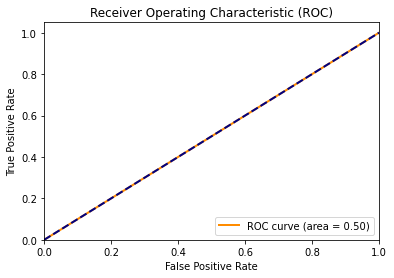

Metrics saved successfully


In [52]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+GRU+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Attention Mechanism+Dense

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate, Reshape, Permute, Multiply
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (224, 224, 3)

# Load MobileNet pre-trained on ImageNet without including the top (classification) layer
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = Dense(1, activation='softmax')(base_model.output)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add a global average pooling layer
x = GlobalAveragePooling2D()(attention_mul)

# Add a fully connected layer with 256 neurons
x = Dense(256, activation='relu')(x)

# Add the final classification layer with softmax activation
predictions = Dense(2, activation='softmax')(x)  # Assuming 2 classes: 'normal' and 'osteoarthritis'

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Preprocess the data
X_train_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_train)
X_val_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_val)
X_test_preprocessed = tf.keras.applications.mobilenet.preprocess_input(X_test)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

                                                                                                  
 conv_pw_5 (Conv2D)          (None, 28, 28, 256)          65536     ['conv_dw_5_relu[0][0]']      
                                                                                                  
 conv_pw_5_bn (BatchNormali  (None, 28, 28, 256)          1024      ['conv_pw_5[0][0]']           
 zation)                                                                                          
                                                                                                  
 conv_pw_5_relu (ReLU)       (None, 28, 28, 256)          0         ['conv_pw_5_bn[0][0]']        
                                                                                                  
 conv_pad_6 (ZeroPadding2D)  (None, 29, 29, 256)          0         ['conv_pw_5_relu[0][0]']      
                                                                                                  
 conv_dw_6

 conv_pw_10_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_pw_10_bn[0][0]']       
                                                                                                  
 conv_dw_11 (DepthwiseConv2  (None, 14, 14, 512)          4608      ['conv_pw_10_relu[0][0]']     
 D)                                                                                               
                                                                                                  
 conv_dw_11_bn (BatchNormal  (None, 14, 14, 512)          2048      ['conv_dw_11[0][0]']          
 ization)                                                                                         
                                                                                                  
 conv_dw_11_relu (ReLU)      (None, 14, 14, 512)          0         ['conv_dw_11_bn[0][0]']       
                                                                                                  
 conv_pw_1

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 199ms/step - loss: 0.7288 - accuracy: 0.5009 - val_loss: 0.7006 - val_accuracy: 0.4875
Epoch 2/50
70/70 [==============================] - 14s 196ms/step - loss: 0.6955 - accuracy: 0.5036 - val_loss: 0.7122 - val_accuracy: 0.4875
Epoch 3/50
70/70 [==============================] - 14s 197ms/step - loss: 0.6971 - accuracy: 0.5161 - val_loss: 0.6837 - val_accuracy: 0.5536
Epoch 4/50
70/70 [==============================] - 14s 197ms/step - loss: 0.6895 - accuracy: 0.5246 - val_loss: 0.6845 - val_accuracy: 0.4875
Epoch 5/50
70/70 [==============================] - 14s 198ms/step - loss: 0.6976 - accuracy: 0.5152 - val_loss: 0.7300 - val_accuracy: 0.4875
Epoch 6/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6940 - accuracy: 0.5246 - val_loss: 0.6763 - val_accuracy: 0.6196
Epoch 7/50
70/70 [==============================] - 14s 203ms/step - loss: 0.6867 - accuracy: 0.5571 - val_loss: 0.6947 - val_accuracy: 0.5357

Validation Loss: 0.6726587414741516
Validation Accuracy: 0.5910714268684387
Test Loss: 0.6765435338020325
Test Accuracy: 0.5841666460037231
Inference Time (Test set): 9.168968915939331 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.92      0.70       622
           1       0.72      0.23      0.34       578

    accuracy                           0.58      1200
   macro avg       0.64      0.57      0.52      1200
weighted avg       0.64      0.58      0.53      1200

Confusion Matrix:
[[570  52]
 [447 131]]


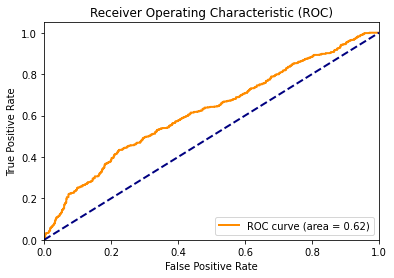

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 14s 205ms/step - loss: 0.6851 - accuracy: 0.5384 - val_loss: 0.6733 - val_accuracy: 0.5750
Epoch 2/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6876 - accuracy: 0.5362 - val_loss: 0.6783 - val_accuracy: 0.5089
Epoch 3/100
70/70 [==============================] - 14s 204ms/step - loss: 0.6903 - accuracy: 0.5371 - val_loss: 0.6866 - val_accuracy: 0.5464
Epoch 4/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6833 - accuracy: 0.5527 - val_loss: 0.6719 - val_accuracy: 0.6018
Epoch 5/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6774 - accuracy: 0.5607 - val_loss: 0.6862 - val_accuracy: 0.4875
Epoch 6/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6890 - accuracy: 0.5312 - val_loss: 0.6824 - val_accuracy: 0.4893
Epoch 7/100
70/70 [==============================] - 14s 203ms/step - loss: 0.6753 - accuracy: 0.5737 - val_loss: 0.6725 - val_accuracy:

Validation Loss: 0.6610531210899353
Validation Accuracy: 0.6339285969734192
Test Loss: 0.6678125262260437
Test Accuracy: 0.596666693687439
Inference Time (Test set): 9.1111741065979 seconds
38/38 [==============================] - 6s 158ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.84      0.68       622
           1       0.66      0.33      0.44       578

    accuracy                           0.60      1200
   macro avg       0.62      0.59      0.56      1200
weighted avg       0.62      0.60      0.57      1200

Confusion Matrix:
[[525  97]
 [387 191]]


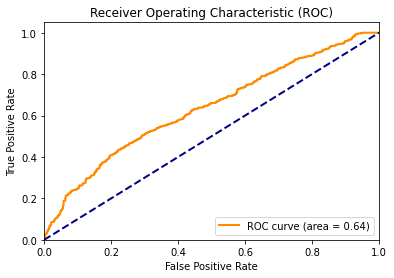

Metrics saved successfully


In [10]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [11]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 14s 204ms/step - loss: 0.6794 - accuracy: 0.5491 - val_loss: 0.6765 - val_accuracy: 0.5607
Epoch 2/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6741 - accuracy: 0.5621 - val_loss: 0.6621 - val_accuracy: 0.6411
Epoch 3/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6710 - accuracy: 0.5696 - val_loss: 0.6702 - val_accuracy: 0.5286
Epoch 4/150
70/70 [==============================] - 14s 202ms/step - loss: 0.6701 - accuracy: 0.5844 - val_loss: 0.6671 - val_accuracy: 0.5786
Epoch 5/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6728 - accuracy: 0.5683 - val_loss: 0.6629 - val_accuracy: 0.5893
Epoch 6/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6725 - accuracy: 0.5701 - val_loss: 0.6652 - val_accuracy: 0.5839
Epoch 7/150
70/70 [==============================] - 14s 203ms/step - loss: 0.6759 - accuracy: 0.5763 - val_loss: 0.6729 - val_accuracy:

Validation Loss: 0.6620846390724182
Validation Accuracy: 0.6410714387893677
Test Loss: 0.6697613596916199
Test Accuracy: 0.6066666841506958
Inference Time (Test set): 9.165776252746582 seconds
38/38 [==============================] - 6s 159ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.69      0.65       622
           1       0.61      0.51      0.56       578

    accuracy                           0.61      1200
   macro avg       0.61      0.60      0.60      1200
weighted avg       0.61      0.61      0.60      1200

Confusion Matrix:
[[431 191]
 [281 297]]


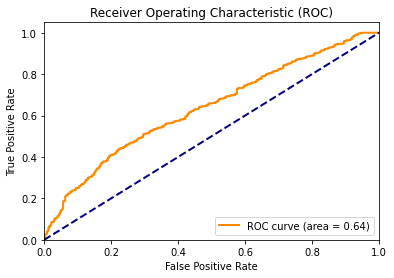

Metrics saved successfully


In [12]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [13]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 14s 205ms/step - loss: 0.6701 - accuracy: 0.5777 - val_loss: 0.6741 - val_accuracy: 0.5143
Epoch 2/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6705 - accuracy: 0.5795 - val_loss: 0.6580 - val_accuracy: 0.6429
Epoch 3/200
70/70 [==============================] - 14s 204ms/step - loss: 0.6704 - accuracy: 0.5879 - val_loss: 0.6575 - val_accuracy: 0.6625
Epoch 4/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6764 - accuracy: 0.5621 - val_loss: 0.6600 - val_accuracy: 0.6196
Epoch 5/200
70/70 [==============================] - 14s 203ms/step - loss: 0.6819 - accuracy: 0.5603 - val_loss: 0.6790 - val_accuracy: 0.4964
Epoch 6/200
70/70 [==============================] - 14s 205ms/step - loss: 0.6749 - accuracy: 0.5638 - val_loss: 0.6648 - val_accuracy: 0.5661
Epoch 7/200
70/70 [==============================] - 14s 199ms/step - loss: 0.6701 - accuracy: 0.5857 - val_loss: 0.6627 - val_accuracy:

Validation Loss: 0.6575008034706116
Validation Accuracy: 0.6625000238418579
Test Loss: 0.6652191877365112
Test Accuracy: 0.60916668176651
Inference Time (Test set): 8.882917404174805 seconds
38/38 [==============================] - 6s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.83      0.69       622
           1       0.67      0.38      0.48       578

    accuracy                           0.61      1200
   macro avg       0.63      0.60      0.58      1200
weighted avg       0.63      0.61      0.59      1200

Confusion Matrix:
[[514 108]
 [361 217]]


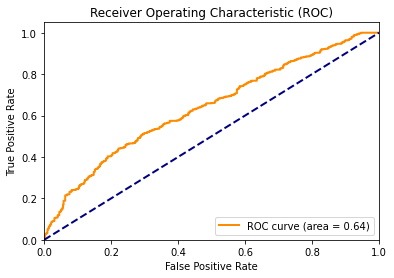

Metrics saved successfully


In [14]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Attention Mechanism +Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")

# MobileNet+Capsule Network+Dense

In [6]:
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, cohen_kappa_score, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer, GlobalAveragePooling2D, Reshape, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import pandas as pd

# Start time
start_time = time.time()

# Assume X_train, X_test, y_train, y_test are available

# Modify the data shapes based on the model requirements
X_train_resized = np.array([cv2.resize(img, (224, 224)) for img in X_train])
X_train_resized = np.expand_dims(X_train_resized, axis=-1)  # Add channel dimension
X_train_resized = np.repeat(X_train_resized, 3, axis=-1)  # Repeat the channel dimension to match the expected input shape of MobileNet

X_test_resized = np.array([cv2.resize(img, (224, 224)) for img in X_test])
X_test_resized = np.expand_dims(X_test_resized, axis=-1)
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)

# Define Capsule Layer
class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        self.W = self.add_weight(shape=[input_dim_capsule, self.num_capsule * self.dim_capsule],
                                 initializer='glorot_uniform',
                                 name='W')

    def call(self, u_vecs):
        u_hat_vecs = tf.reduce_sum(tf.expand_dims(u_vecs, -1) * tf.expand_dims(self.W, 0), axis=-2)
        b = tf.zeros(shape=[tf.shape(u_hat_vecs)[0], self.num_capsule])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=1)
            s_j = tf.reduce_sum(tf.multiply(c[:, :, None], u_hat_vecs), axis=1)
            v_j = self.squash(s_j)
            if i < self.routings - 1:
                b += tf.reduce_sum(tf.multiply(v_j[:, None, :], u_hat_vecs), axis=-1)
        return v_j

    def squash(self, s_j):
        s_squared_norm = tf.reduce_sum(tf.square(s_j), axis=-1, keepdims=True)
        scale = s_squared_norm / (1 + s_squared_norm) / tf.sqrt(s_squared_norm + tf.keras.backend.epsilon())
        return scale * s_j


# Load pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add Capsule Network
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Reshape((-1, 1024))(x)  # Reshape to 3D tensor for Capsule Network
x = CapsuleLayer(num_capsule=10, dim_capsule=16, routings=3)(x)  # Example: 10 capsules with dimension 16
x = Flatten()(x)  # Flatten the output
x = Dense(128, activation='relu')(x)
output = Dense(2, activation='softmax')(x)  # Use softmax activation for multi-class classification

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

 )                                                               
                                                                 
 conv_dw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_dw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_pw_8 (Conv2D)          (None, 14, 14, 512)       262144    
                                                                 
 conv_pw_8_bn (BatchNormali  (None, 14, 14, 512)       2048      
 zation)                                                         
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 512)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D  (None, 14, 14, 512)       4608      
 )        

In [9]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=50, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/50
70/70 [==============================] - 15s 201ms/step - loss: 0.5233 - accuracy: 0.7161 - val_loss: 0.4009 - val_accuracy: 0.8179
Epoch 2/50
70/70 [==============================] - 14s 197ms/step - loss: 0.3639 - accuracy: 0.8366 - val_loss: 0.3366 - val_accuracy: 0.8357
Epoch 3/50
70/70 [==============================] - 14s 199ms/step - loss: 0.3002 - accuracy: 0.8679 - val_loss: 0.3145 - val_accuracy: 0.8571
Epoch 4/50
70/70 [==============================] - 14s 199ms/step - loss: 0.2695 - accuracy: 0.8799 - val_loss: 0.3596 - val_accuracy: 0.8446
Epoch 5/50
70/70 [==============================] - 14s 199ms/step - loss: 0.2223 - accuracy: 0.9085 - val_loss: 0.2948 - val_accuracy: 0.8911
Epoch 6/50
70/70 [==============================] - 14s 200ms/step - loss: 0.2238 - accuracy: 0.8973 - val_loss: 0.3066 - val_accuracy: 0.8804
Epoch 7/50
70/70 [==============================] - 14s 205ms/step - loss: 0.1724 - accuracy: 0.9263 - val_loss: 0.3050 - val_accuracy: 0.8857

Validation Loss: 0.2810133695602417
Validation Accuracy: 0.8892857432365417
Test Loss: 0.27796077728271484
Test Accuracy: 0.89083331823349
Inference Time (Test set): 9.843628644943237 seconds
38/38 [==============================] - 7s 160ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       622
           1       0.89      0.88      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

Confusion Matrix:
[[558  64]
 [ 67 511]]


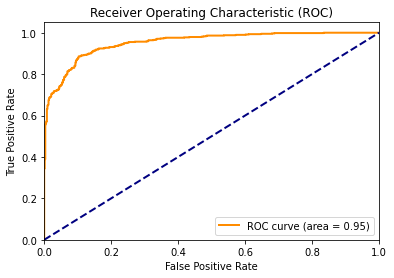

Metrics saved successfully


In [10]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_50_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_50_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=100, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/100
70/70 [==============================] - 15s 201ms/step - loss: 0.4757 - accuracy: 0.7656 - val_loss: 0.3870 - val_accuracy: 0.8268
Epoch 2/100
70/70 [==============================] - 14s 195ms/step - loss: 0.3635 - accuracy: 0.8313 - val_loss: 0.3178 - val_accuracy: 0.8482
Epoch 3/100
70/70 [==============================] - 14s 198ms/step - loss: 0.3099 - accuracy: 0.8629 - val_loss: 0.3217 - val_accuracy: 0.8571
Epoch 4/100
70/70 [==============================] - 14s 198ms/step - loss: 0.2490 - accuracy: 0.9013 - val_loss: 0.3100 - val_accuracy: 0.8679
Epoch 5/100
70/70 [==============================] - 14s 199ms/step - loss: 0.2099 - accuracy: 0.9085 - val_loss: 0.3622 - val_accuracy: 0.8482
Epoch 6/100
70/70 [==============================] - 14s 199ms/step - loss: 0.2316 - accuracy: 0.8951 - val_loss: 0.3181 - val_accuracy: 0.8625
Epoch 7/100
70/70 [==============================] - 14s 203ms/step - loss: 0.1687 - accuracy: 0.9299 - val_loss: 0.3066 - val_accuracy:

Validation Loss: 0.3040260970592499
Validation Accuracy: 0.8964285850524902
Test Loss: 0.3044568598270416
Test Accuracy: 0.8799999952316284
Inference Time (Test set): 10.041381359100342 seconds
38/38 [==============================] - 7s 155ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       622
           1       0.91      0.84      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.88      0.88      1200
weighted avg       0.88      0.88      0.88      1200

Confusion Matrix:
[[572  50]
 [ 94 484]]


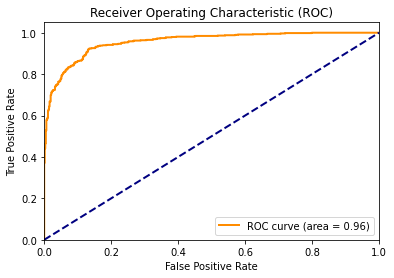

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_100_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_100_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=150, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/150
70/70 [==============================] - 15s 203ms/step - loss: 0.5107 - accuracy: 0.7464 - val_loss: 0.4545 - val_accuracy: 0.7750
Epoch 2/150
70/70 [==============================] - 14s 203ms/step - loss: 0.3824 - accuracy: 0.8232 - val_loss: 0.3345 - val_accuracy: 0.8500
Epoch 3/150
70/70 [==============================] - 14s 203ms/step - loss: 0.2950 - accuracy: 0.8723 - val_loss: 0.3002 - val_accuracy: 0.8750
Epoch 4/150
70/70 [==============================] - 14s 204ms/step - loss: 0.2735 - accuracy: 0.8799 - val_loss: 0.2788 - val_accuracy: 0.8875
Epoch 5/150
70/70 [==============================] - 14s 205ms/step - loss: 0.2278 - accuracy: 0.9058 - val_loss: 0.2838 - val_accuracy: 0.8714
Epoch 6/150
70/70 [==============================] - 14s 207ms/step - loss: 0.2084 - accuracy: 0.9071 - val_loss: 0.2699 - val_accuracy: 0.8946
Epoch 7/150
70/70 [==============================] - 14s 206ms/step - loss: 0.1917 - accuracy: 0.9183 - val_loss: 0.3070 - val_accuracy:

Validation Loss: 0.2538045048713684
Validation Accuracy: 0.8928571343421936
Test Loss: 0.27017223834991455
Test Accuracy: 0.8891666531562805
Inference Time (Test set): 10.248637437820435 seconds
38/38 [==============================] - 7s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       622
           1       0.87      0.90      0.89       578

    accuracy                           0.89      1200
   macro avg       0.89      0.89      0.89      1200
weighted avg       0.89      0.89      0.89      1200

Confusion Matrix:
[[547  75]
 [ 58 520]]


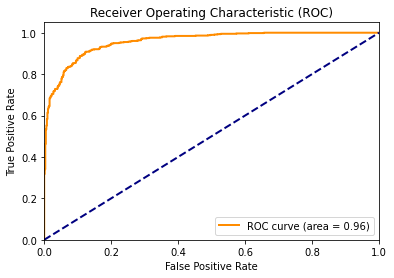

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_150_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_150_metrics.csv',index=False)
print("Metrics saved successfully")

In [7]:
import time
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Record start time
start_time = time.time()

# Fit the model
history = model.fit(X_train_preprocessed, y_train_categorical, 
                    validation_data=(X_val_preprocessed, y_val_categorical), 
                    epochs=200, 
                    callbacks=[early_stopping])

# Record end time
end_time = time.time()

# Calculate training time
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")


Epoch 1/200
70/70 [==============================] - 15s 204ms/step - loss: 0.5298 - accuracy: 0.7299 - val_loss: 0.4395 - val_accuracy: 0.8089
Epoch 2/200
70/70 [==============================] - 14s 204ms/step - loss: 0.3486 - accuracy: 0.8464 - val_loss: 0.3238 - val_accuracy: 0.8518
Epoch 3/200
70/70 [==============================] - 14s 203ms/step - loss: 0.2903 - accuracy: 0.8719 - val_loss: 0.3029 - val_accuracy: 0.8696
Epoch 4/200
70/70 [==============================] - 14s 203ms/step - loss: 0.2572 - accuracy: 0.8835 - val_loss: 0.3647 - val_accuracy: 0.8482
Epoch 5/200
70/70 [==============================] - 14s 203ms/step - loss: 0.2364 - accuracy: 0.8982 - val_loss: 0.2847 - val_accuracy: 0.8929
Epoch 6/200
70/70 [==============================] - 14s 203ms/step - loss: 0.2013 - accuracy: 0.9089 - val_loss: 0.3465 - val_accuracy: 0.8571
Epoch 7/200
70/70 [==============================] - 14s 204ms/step - loss: 0.1755 - accuracy: 0.9241 - val_loss: 0.3147 - val_accuracy:

Validation Loss: 0.28473392128944397
Validation Accuracy: 0.8928571343421936
Test Loss: 0.29767537117004395
Test Accuracy: 0.875
Inference Time (Test set): 9.902340650558472 seconds
38/38 [==============================] - 7s 161ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       622
           1       0.89      0.85      0.87       578

    accuracy                           0.88      1200
   macro avg       0.88      0.87      0.87      1200
weighted avg       0.88      0.88      0.87      1200

Confusion Matrix:
[[560  62]
 [ 88 490]]


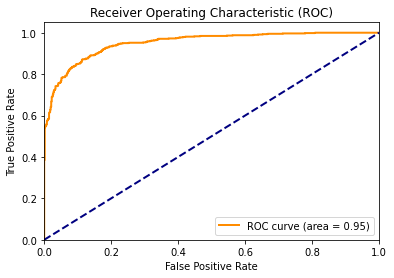

Metrics saved successfully


In [8]:
import numpy as np
import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Record start time for inference on test set
start_inference_time = time.time()

# Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(X_val_preprocessed, y_val_categorical, verbose=0)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test_preprocessed, y_test_categorical, verbose=0)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Record end time for inference on test set
end_inference_time = time.time()

# Calculate inference time for test set
inference_time = end_inference_time - start_inference_time
print(f"Inference Time (Test set): {inference_time} seconds")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
existing_metrics_df=pd.read_csv('MobileNet_4000_epoch_200_metrics.csv')
metrics={
    'Combination':['MobileNet+Capsule Network+Dense'],
    'Validation Accuracy':[val_accuracy*100],
    'Validation Loss':[val_loss],
    'Test Accuracy':[test_accuracy*100],
    'Test Loss':[test_loss],
    'Training time':[training_time],
    'Inference time':[inference_time],
    'Cohens Kappa':[kappa],
    'MCC':[mcc],
    'Balanced Accuracy':[balanced_accuracy]
}
new_metrics_df=pd.DataFrame(metrics)
updated_metrics_df=pd.concat([existing_metrics_df,new_metrics_df],ignore_index=True)
updated_metrics_df.to_csv('MobileNet_4000_epoch_200_metrics.csv',index=False)
print("Metrics saved successfully")